In [4]:
import lightglue
import matplotlib.pyplot as plt
import pandas as pd
import imageio.v2 as imageio
import kornia.feature as KF
import numpy as np
import json
import pycolmap
import os

## Accumulate mAA   

In [20]:
directory = 'outputs'
df = pd.DataFrame()

for filename in os.listdir(directory):
    if filename.endswith('_scores.json'):
        prefix = filename.split('_')[0]
        filepath = os.path.join(directory, filename)
        print(filepath)
        with open(filepath, 'r') as file:
            data = json.load(file)
        if isinstance(data, list):
            temp_df = pd.DataFrame.from_dict(data[0], orient='index', columns=[prefix])
        else:
            temp_df = pd.DataFrame.from_dict(data, orient='index', columns=[prefix])        
        df = pd.concat([df, temp_df], axis=1)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Dataset'}, inplace=True)

print(df)

outputs/ALIKED_scores.json
outputs/DoGHardNet_scores.json
outputs/DISK_scores.json
outputs/D2Net_scores.json
outputs/SIFT_scores.json
outputs/LOFTR_scores.json
outputs/dfsfm_scores.json
outputs/SuperPoint_scores.json
                            Dataset  ALIKED  DoGHardNet    DISK   D2Net  \
0                            church  0.2975      0.2710  0.2897  0.1712   
1                          dioscuri  0.1692      0.2935  0.3010     NaN   
2                            lizard  0.8039      0.3424  0.6950     NaN   
3  multi-temporal-temple-baalshamin  0.2169      0.1878  0.2540     NaN   
4                              pond  0.6497      0.4399  0.5034     NaN   
5              transp_obj_glass_cup  0.0152      0.0354  0.0354     NaN   
6         transp_obj_glass_cylinder  0.0303      0.0303  0.0000     NaN   

     SIFT   LOFTR     dfsfm  SuperPoint  
0  0.2617  0.2445  0.200935      0.1698  
1  0.3234  0.0174  0.057214      0.1542  
2  0.3662  0.6213  0.612245      0.7698  
3  0.1984  0.1

In [32]:
import lightglue
import kornia.feature as KF
import cv2
def aliked(img1, img2):
    im1 = lightglue.utils.load_image(img1)
    im2 = lightglue.utils.load_image(img2)
    extractor = lightglue.ALIKED(
                max_num_keypoints=4096,
                detection_threshold=0.0,
                resize=640,
            ).eval()
    feats1 = extractor.extract(im1)
    feats2 = extractor.extract(im2)
    matcher = KF.LightGlueMatcher("aliked",{"width_confidence": -1, "depth_confidence": -1}).eval()
    _, matches = matcher(feats1["descriptors"], feats2["descriptors"],
                        KF.laf_from_center_scale_ori(feats1["keypoints"]),
                        KF.laf_from_center_scale_ori(feats2["keypoints"]))
     # Convert images to BGR for OpenCV
    img1_bgr = cv2.cvtColor(im1.numpy(), cv2.COLOR_RGB2BGR)
    img2_bgr = cv2.cvtColor(im2.numpy(), cv2.COLOR_RGB2BGR)

    [print(p) for p in feats1["keypoints"][matches[0],:]]
    # Draw matches using OpenCV
    matched_img = cv2.drawMatches(
        img1_bgr, [cv2.KeyPoint(int(p[0]), int(p[1]), 1) for p in feats1["keypoints"].shape],
        img2_bgr, [cv2.KeyPoint(int(p[0]), int(p[1]), 1) for p in feats2["keypoints"]],
        matches,
        None,
        matchColor=(0, 255, 0),
        singlePointColor=(255, 0, 0),
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Convert back to RGB for matplotlib
    matched_img_rgb = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.figure(figsize=(20, 10))
    plt.imshow(matched_img_rgb)
    plt.axis('off')
    plt.show()

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/aliked_lightglue.pth" to /home/niranjan/.cache/torch/hub/checkpoints/aliked_lightglue_v0-1_arxiv.pth
100%|██████████| 45.4M/45.4M [00:00<00:00, 139MB/s] 


In [1]:
from lightglue import LightGlue, ALIKED, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
import kornia.feature as KF
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

def aliked_loftr(im0,im1):
    extractor = ALIKED(max_num_keypoints=2048).eval().to(device)  # load the extractor
    matcher = LightGlue(features="aliked").eval().to(device)
    image0 = load_image(im0)
    image1 = load_image(im1)

    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

    axes = viz2d.plot_images([image0, image1])
    viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
    res = KF.LoFTR("outdoor")({"image0":image0.mean(dim=0,keepdim=True).unsqueeze(0), "image1":image1.mean(dim=0,keepdim=True).unsqueeze(0)})
    axes = viz2d.plot_images([image0, image1])
    viz2d.plot_matches(res["keypoints0"], res["keypoints1"], color="lime", lw=0.2)

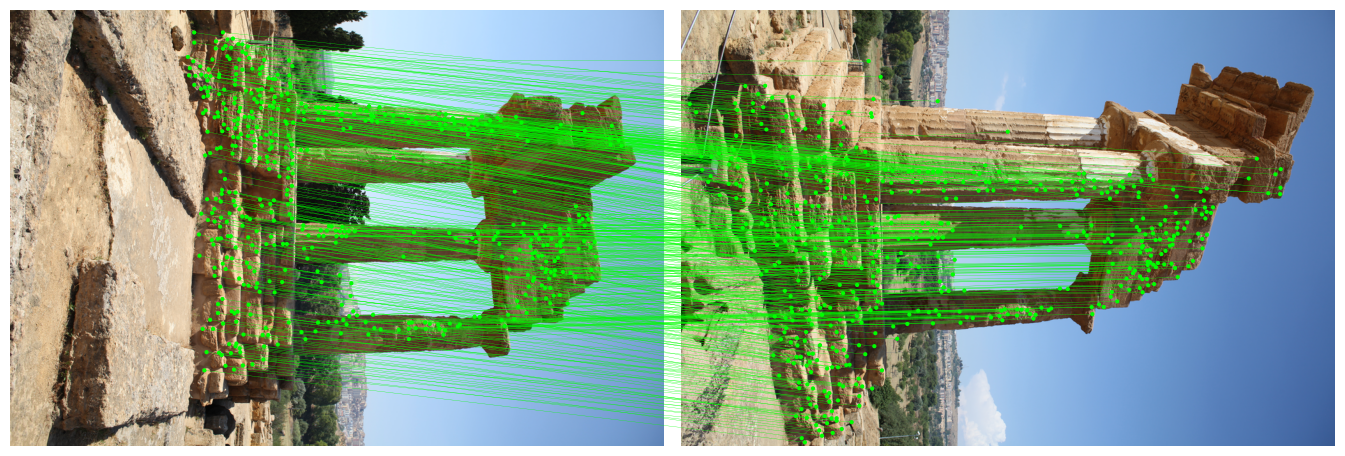

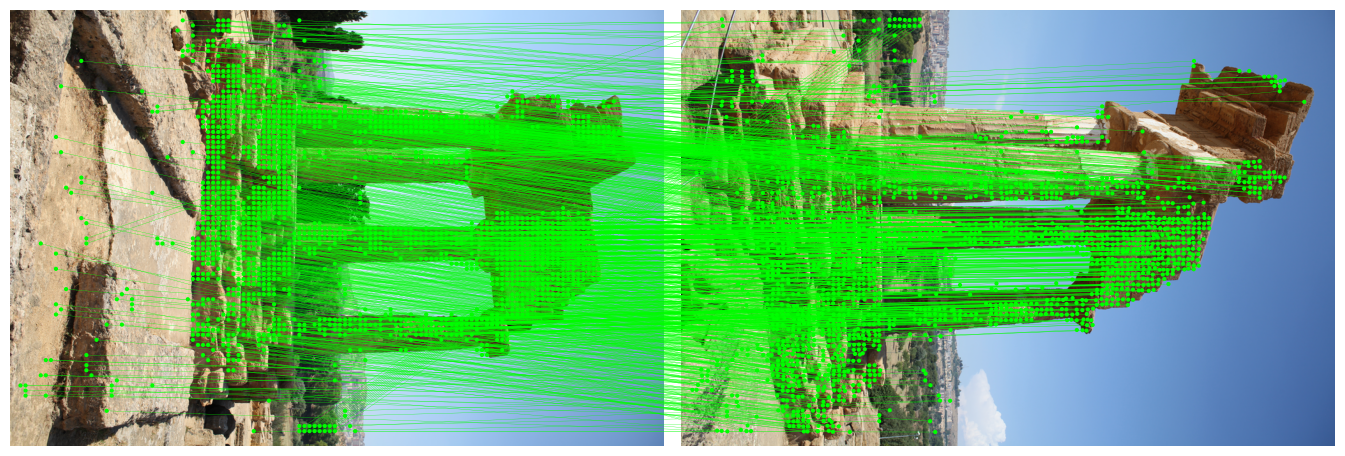

In [2]:
aliked_loftr("/home/niranjan/recons3d/dataset/train/dioscuri/images/3dom_fbk_img_1512.png", "dataset/train/dioscuri/images/3dom_fbk_img_1517.png")

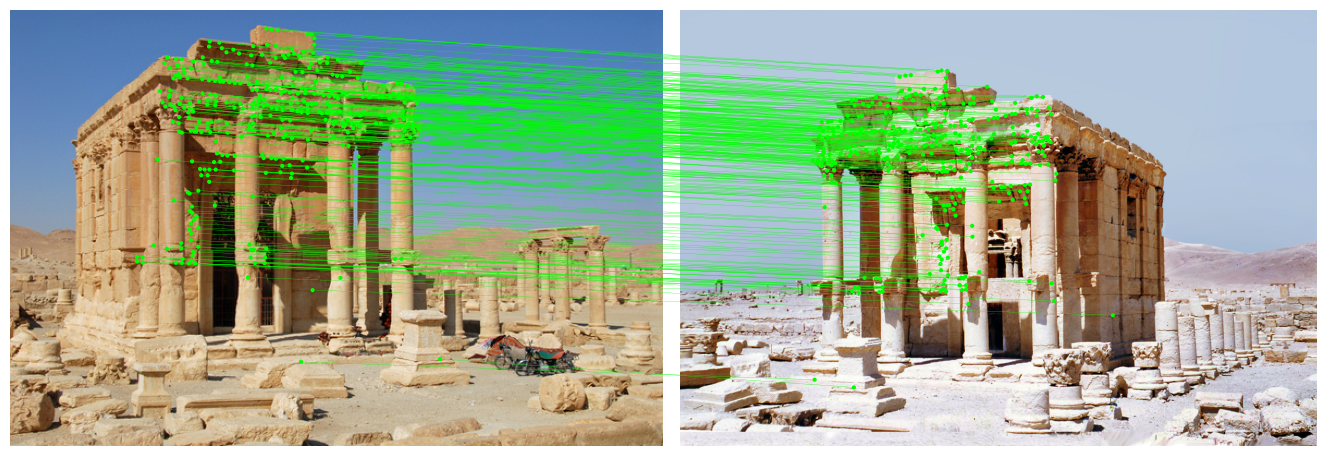

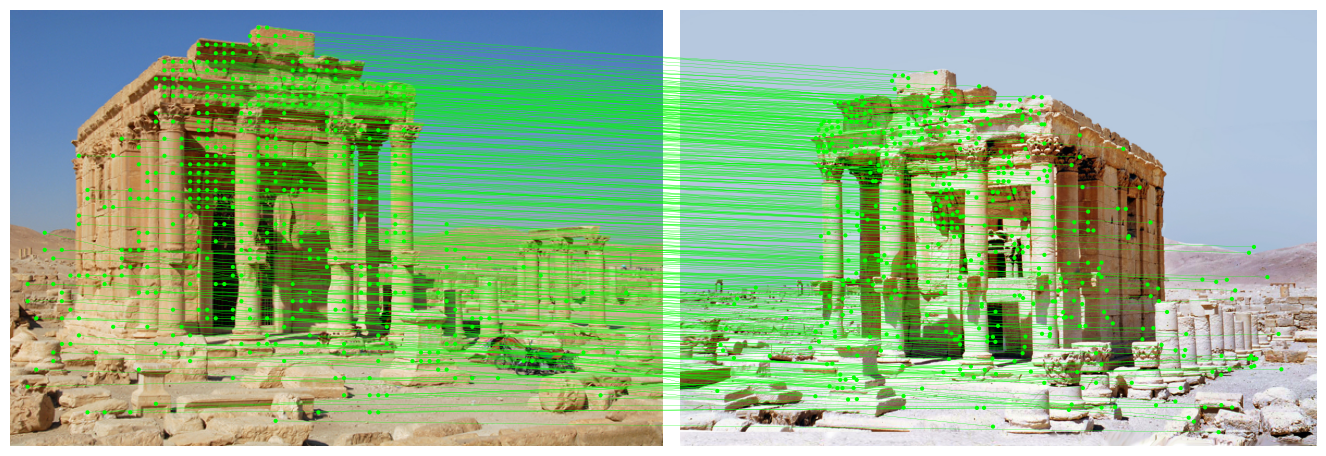

In [6]:
aliked_loftr("/home/niranjan/recons3d/dataset/train/multi-temporal-temple-baalshamin/images/2316.png", "dataset/train/multi-temporal-temple-baalshamin/images/194d.png")

In [3]:
aliked_loftr("/home/niranjan/recons3d/dataset/train/transp_obj_glass_cylinder/images/dsc_8232.png", "/home/niranjan/recons3d/dataset/train/transp_obj_glass_cylinder/images/dsc_8233.png")

: 

In [ ]:
aliked("/home/niranjan/recons3d/dataset/train/dioscuri/images/archive_0003.png", "/home/niranjan/recons3d/dataset/train/dioscuri/images/archive_0003.png")

Loaded LightGlue model
tensor([[278.9485, 756.6967],
        [566.9905, 969.4010],
        [321.7614, 368.1305],
        ...,
        [  3.9387, 773.0419],
        [225.7978, 690.3160],
        [203.0434, 671.0480]])


ValueError: only one element tensors can be converted to Python scalars

### Visualize 3D Recons

In [11]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 25.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 24.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.2 MB/s eta 0:00:00a 0:00:01


In [19]:
import struct
import numpy as np

import open3d as o3d

def visualize_points(points3d):
    points = []
    colors = []
    for point in points3d.values():
        points.append(point['xyz'])
        colors.append(point['rgb'] / 255.0) 

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(np.array(points))
    point_cloud.colors = o3d.utility.Vector3dVector(np.array(colors))
    o3d.visualization.draw_geometries([point_cloud])


def read_points3d_binary(file_path):
    points3d = {}
    with open(file_path, 'rb') as f:
        num_points = struct.unpack('Q', f.read(8))[0]
        for _ in range(num_points):
            point_id = struct.unpack('Q', f.read(8))[0]
            xyz = struct.unpack('3d', f.read(24))
            rgb = struct.unpack('3B', f.read(3))
            error = struct.unpack('d', f.read(8))[0]
            track_length = struct.unpack('Q', f.read(8))[0]
            
            # Skip the track elements to avoid memory errors
            # f.read(track_length * 16)
            
            points3d[point_id] = {
                'xyz': np.array(xyz),
                'rgb': np.array(rgb),
                'error': error
            }
    return points3d

from mpl_toolkits.mplot3d import Axes3D



file_path = '/home/niranjan/recons3d/dataset/train/multi-temporal-temple-baalshamin_trimmed/DetectorFreeSfM_loftr_official_coarse_fine__scratch_no_intrin/colmap_refined/points3D.bin'
points3d = read_points3d_binary(file_path)
visualize_points(points3d)

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
